In [1]:
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')

In [5]:
class HodgkinHuxleyModel:
    def __init__(self, dt=1e-3, solver="RK4"):
        # -----------------------------
        # 定数（生理学的パラメータ）
        # -----------------------------
        self.C_m = 1.0  # 膜容量 [μF/cm^2]：膜電位の変化に対する電荷保持能力
        self.g_Na = 120.0  # Na+ チャネルの最大コンダクタンス [mS/cm^2]
        self.g_K = 36.0  # K+ チャネルの最大コンダクタンス [mS/cm^2]
        self.g_L = 0.3  # 漏れ（Leak）チャネルのコンダクタンス [mS/cm^2]
        self.E_Na = 50.0  # Na+ の平衡電位 [mV]
        self.E_K = -77.0  # K+ の平衡電位 [mV]
        self.E_L = -54.387  # 漏れ電位 [mV]

        # -----------------------------
        # 数値積分設定
        # -----------------------------
        self.solver = solver  # 数値解法（Runge-Kutta 4次 or Euler）
        self.dt = dt  # 時間刻み幅 [ms]

        # -----------------------------
        # 状態変数の初期値
        # -----------------------------
        # states = [V, m, h, n]
        # V: 膜電位, m/h/n: ゲート変数（Na+/K+チャネルの開閉確率）
        self.states = np.array([-65, 0.05, 0.6, 0.32])
        self.I_m = None  # 外部入力電流 [μA/cm^2]

    # ======================================================
    # Runge-Kutta 4次法またはEuler法による数値積分
    # ======================================================
    def Solvers(self, func, x, dt):
        # func: 状態変数の時間微分を返す関数（ここでは dALLdt）
        # x: 現在の状態ベクトル
        # dt: 時間刻み幅

        if self.solver == "RK4":
            # -----------------------------
            # Runge-Kutta 4次法による1ステップ更新
            # 高精度な常微分方程式(ODE)の数値解法
            # -----------------------------
            k1 = dt * func(x)
            k2 = dt * func(x + 0.5 * k1)
            k3 = dt * func(x + 0.5 * k2)
            k4 = dt * func(x + k3)
            # 重み付き平均で次の状態を計算
            return x + (k1 + 2 * k2 + 2 * k3 + k4) / 6

        elif self.solver == "Euler":
            # -----------------------------
            # 陽的Euler法（最も単純な積分法）
            # 誤差は大きいが高速
            # -----------------------------
            return x + dt * func(x)
        else:
            return None

    # ======================================================
    # ゲート変数の速度定数（α, β）
    # これらは膜電位Vに依存して変化する
    # ======================================================
    def alpha_m(self, V):
        # Na+ チャネルの活性化ゲート m の開口率増加速度
        return 0.1 * (V + 40.0) / (1.0 - np.exp(-(V + 40.0) / 10.0))

    def beta_m(self, V):
        # Na+ チャネル m の閉鎖速度
        return 4.0 * np.exp(-(V + 65.0) / 18.0)

    def alpha_h(self, V):
        # Na+ チャネルの不活性化ゲート h の閉鎖速度
        return 0.07 * np.exp(-(V + 65.0) / 20.0)

    def beta_h(self, V):
        # Na+ チャネル h の再活性化速度
        return 1.0 / (1.0 + np.exp(-(V + 35.0) / 10.0))

    def alpha_n(self, V):
        # K+ チャネルの活性化ゲート n の開口速度
        return 0.01 * (V + 55.0) / (1.0 - np.exp(-(V + 55.0) / 10.0))

    def beta_n(self, V):
        # K+ チャネル n の閉鎖速度
        return 0.125 * np.exp(-(V + 65) / 80.0)

    # ======================================================
    # 各イオン電流の計算
    # ------------------------------------------------------
    # I_ion = g_ion * (V - E_ion)
    # ただし、Na+, K+ はゲート変数による確率的開閉を考慮
    # ======================================================
    def I_Na(self, V, m, h):
        # Na+電流 [μA/cm^2]
        # 3つのmゲートと1つのhゲートで開閉を制御
        return self.g_Na * m**3 * h * (V - self.E_Na)

    def I_K(self, V, n):
        # K+電流 [μA/cm^2]
        # 4つのnゲートで制御
        return self.g_K * n**4 * (V - self.E_K)

    def I_L(self, V):
        # 漏れ電流 [μA/cm^2]
        # ゲート変数なし、一定のコンダクタンスを持つ
        return self.g_L * (V - self.E_L)

    # ======================================================
    # Hodgkin-Huxley方程式の微分方程式系
    # ======================================================
    def dALLdt(self, states):
        # 状態ベクトルを展開
        V, m, h, n = states

        # 1. 膜電位の変化率 dV/dt
        #    = (外部電流 - 各イオン電流) / 膜容量
        dVdt = (self.I_m - self.I_Na(V, m, h) - self.I_K(V, n) - self.I_L(V)) / self.C_m

        # 2. ゲート変数の変化率
        #    dm/dt = α_m(V)(1-m) - β_m(V)m
        dmdt = self.alpha_m(V) * (1.0 - m) - self.beta_m(V) * m
        dhdt = self.alpha_h(V) * (1.0 - h) - self.beta_h(V) * h
        dndt = self.alpha_n(V) * (1.0 - n) - self.beta_n(V) * n

        # 各微分値を配列として返す
        return np.array([dVdt, dmdt, dhdt, dndt])

    # ======================================================
    # モデルの1ステップ実行
    # ======================================================
    def __call__(self, I):
        # 外部入力電流をセット
        self.I_m = I

        # dALLdtを使って状態を1ステップ更新
        states = self.Solvers(self.dALLdt, self.states, self.dt)

        # 状態を保存
        self.states = states

        # 更新後の状態 [V, m, h, n] を返す
        return states

In [8]:
# ==============================================================
# シミュレーション設定
# ==============================================================

dt = 0.01  # 時間刻み幅 [ms]
T = 350  # 総シミュレーション時間 [ms]

nt = round(T / dt)  # 総ステップ数（= 総時間 / 刻み幅）
time = np.arange(0.0, T, dt)  # 時間軸の配列（例: [0.00, 0.01, 0.02, ..., 349.99]）

# ==============================================================
# 外部刺激電流 I_inj の設定 [μA/cm^2]
# --------------------------------------------------------------
# 各区間ごとに異なる定常電流を印加する。
# time > t の部分が True のとき、その係数が有効になる。
# True は 1, False は 0 として扱われる。
# ==============================================================

I_inj = (
    10 * (time > 50)  # 50ms以降 +10 μA/cm^2 の刺激
    - 10 * (time > 150)  # 150ms以降 -10 μA/cm^2（つまり刺激を止める）
    + 35 * (time > 200)  # 200ms以降 +35 μA/cm^2 の刺激
    - 35 * (time > 300)  # 300ms以降 -35 μA/cm^2（再び刺激を止める）
)
# → 結果として:
#   0–50ms   : I=0
#   50–150ms : I=+10
#   150–200ms: I=0
#   200–300ms: I=+35
#   300–350ms: I=0

# ==============================================================
# Hodgkin-Huxley モデルのインスタンス作成
# ==============================================================

HH_neuron = HodgkinHuxleyModel(dt=dt, solver="Euler")
# → 1個のニューロンをシミュレーション対象とする。
# solver="Euler" は陽的オイラー法による積分を意味する。
# （RK4よりも高速だが、精度はやや低い）

# ==============================================================
# 結果を記録するための配列
# --------------------------------------------------------------
# X_arr の各列:
#   [0]: 膜電位 V (mV)
#   [1]: Na+ 活性化ゲート m
#   [2]: Na+ 不活性化ゲート h
#   [3]: K+ 活性化ゲート n
# ==============================================================

X_arr = np.zeros((nt, 4))

# ==============================================================
# 時間発展シミュレーション
# ==============================================================

for i in tqdm(range(nt)):  # tqdm: 進行状況バーの表示
    # 時刻 i における外部刺激電流を入力し、1ステップ進める
    X = HH_neuron(I_inj[i])

    # 出力された [V, m, h, n] を記録配列に格納
    X_arr[i] = X

# ==============================================================
# スパイク（発火）の検出
# --------------------------------------------------------------
# 膜電位Vが負から正に転じたタイミングをスパイクとみなす。
# 具体的には、1ステップ前が負、次のステップで正 → True
# np.bitwise_and は要素ごとの論理積を計算。
# ==============================================================

spike = np.bitwise_and(X_arr[:-1, 0] < 0, X_arr[1:, 0] > 0)

# スパイクの総数を出力
print("Num. of spikes :", np.sum(spike))

  0%|          | 0/35000 [00:00<?, ?it/s]

Num. of spikes : 18


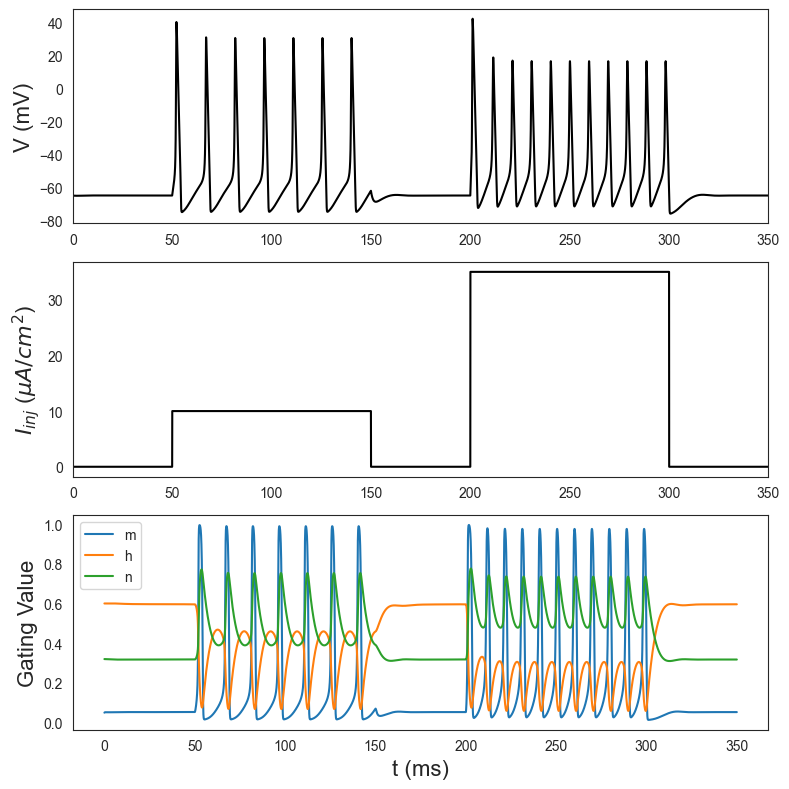

In [9]:
plt.figure(figsize=(8, 8))
plt.subplot(3, 1, 1)
plt.plot(time, X_arr[:, 0], color="k")
plt.ylabel("V (mV)", size=16)
plt.xlim(0, T)

plt.subplot(3, 1, 2)
plt.plot(time, I_inj, color="k")
plt.ylabel("$I_{inj}$ ($\\mu{A}/cm^2$)", size=16)
plt.xlim(0, T)
plt.tight_layout()

plt.subplot(3, 1, 3)
plt.plot(time, X_arr[:, 1], label="m")
plt.plot(time, X_arr[:, 2], label="h")
plt.plot(time, X_arr[:, 3], label="n")
plt.xlabel("t (ms)", size=16)
plt.ylabel("Gating Value", size=16)
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()